Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Pasit Tiwawognrut"
ID = "122442"

---

# Lab 12: Generative Adversarial Networks

We have seen that in the unsupervised learning setting, we are given a training dataset
$(\textbf{x}^{(1)}, \ldots, \textbf{x}^{(m)})$, $\textbf{x}^{(i)} \in \mathcal{X}$.
and our goal is to output a model that expresses the structure of the dataset.

Many unsupervised learning algorithms such as the EM algorithm for Gaussian mixture models
estimate a probability density model $h_\theta(\textbf{x}) = p(\textbf{X}=\textbf{x} ; \theta)$.
The GMM is an explicit parametric probability density estimator.

A completely different approach to probability density modeling is represented by the recently
introduced Generative Adversarial Network (GAN) density model.
GANs were [introduced in 2014 by Ian Goodfellow and colleagues](https://arxiv.org/abs/1406.2661).

The idea is simple. We assume that the training data were sampled i.i.d. from a
distribution $p_{\text{data}}(\mathbf{x})$ over $\mathcal{X}$. We define a prior
density $p_\textbf{z}(\textbf{z})$ over a set of possible "noise vectors" $\mathcal{Z}$,
(usually, $\mathcal{Z} = \mathbb{R}^d$), then we try to come up with a neural network *generator*
$G(\mathbf{z};\theta_g)$ whose goal is to transform noise inputs $\mathbf{z} \sim p_\mathbf{z}(\mathbf{z})$
into outputs $\mathbf{x} = G(\mathbf{z};\theta_g)$
distributed (as closely as possible) according to $p_\text{data}(\mathbf{x})$.
We also create and train a neural network *discriminator*
$D(\mathbf{x};\theta_d)$ whose goal is to distinguish "real" samples from the training set from
"fake" samples from $G$.

Formally, $G$ and $D$ play a minimax game with value function $V(D,G)$:
$$\min_G \max_D V(D,G) = \mathbb{E}_{\mathbf{x} \sim p_\text{data}(\mathbf{x})}\left[\log D(\textbf{x})\right] +
                         \mathbb{E}_{\mathbf{z} \sim p_\mathbf{z}(\mathbf{z})}\left[
                           \log(1-D(G(\textbf{z}))\right]. $$
                   
Again, the generator's goal is to "trick" the discriminator into thinking its outputs are samples from
$p_\text{data}(\mathbf{x})$.
The generator *implicitly* defines a probability density $p_g(\mathbf{x})$ over $\mathcal{X}$.
The generator wins the minimax game when $p_g = p_\text{data}$.

One type of application of the GAN is to generate images according to a
target distribution. [Goodfellow's original GAN paper](https://arxiv.org/abs/1406.2661)
demonstrates the ability of their GANs to generate images similar to those in the MNIST
handwritten digit dataset and the CIFAR-10 common object image dataset.
Here is the basic GAN model described by Goodfellow et al. (2014):

<img src="img/gan_architecture-1.png" title="GAN Framework" style="width: 640px;" />

Since 2014, GANs and their cousins have led to some of the most startling advances artificial intelligence
has seen during this time. See, for example, our favorite GAN variant, the
[CycleGAN](https://arxiv.org/abs/1703.10593),
which combines two generators and two discriminators and can do incredibly amazing things like
[turn horses into zebras](https://junyanz.github.io/CycleGAN/) or
[super-resolve images of peoples' faces](https://link.springer.com/article/10.1007%2Fs00521-021-05973-0).

In this lab, we'll develop several basic GANs and experiment with them. Some of the material here is derived
from Coursera's *Build Basic Generative Adversarial Networks*.

After this lab, you may be interested in [6 GAN Architectures You Really Should Know](https://neptune.ai/blog/6-gan-architectures).

## Generator

The generator in a GAN is driven by a noise vector
sampled from the "latent space" $\mathcal{Z}$ according to $p_\mathbf{z}$ and transforms that
noise sample into an element of $\mathcal{X}$, the domain of $p_{data}$.

<img src="img/Generator.jpg" title="Generator" style="width: 640px;" />

The generator in a GAN is used to generate examples and is the model we're invested in and helping
to achieve high performance at the end of the training process.

The generator's final goal is to produce examples from a certain class. So if you trained it from the class of a cat, then the generator will do some computations and output a representation of a cat that looks as real as
possible.

<img src="img/generateCat.PNG" title="Generator-Cat" style="width: 640px;" />

Clearly, yhe generator should not output the same cat every time it runs.
To ensure that it is able to produce different examples each time it is invoked,
we actually input different samples from the noise distribution.

Noise vector is actually just a set of values where these differently shaded cells are just different values. So you can think of this as 1, 2, 5, 1.5, 5, 5, 2. Then this noise vector is fed in as input, sometimes with
additional information such as a class $y$ for the class "cat" into the generator's neural network.
This means that these features, $x_0$, $x_1$, $x_2$, all the way up to $x_n$, include the class, as well as, the numbers in this noise vector. Then the generator in this neural network will compute a series of nonlinearities from those inputs and return some variables that look link an image.

In another run, it may generate a cat or a dog or even a horse. These are all with a different noise vectors and each noise vector can be red nose, short hair and other. These things can be learned from Discriminator model.

## Discriminator

The discriminator has the responsibity to classify its input as
real or fake. When a fake sample from the generator is given, it should ouptut 0 for fake:

<img src="img/DiscriminatorFake.png" title="Discriminator-1" style="width: 640px;" />

On the other hand, if the input is real, it shoudl output 1 for real:

<img src="img/DiscriminatorReal.jpg" title="Discriminator-2" style="width: 640px;" />

Discriminator models is the probability of an example being fake given a set of input $X$. It will look at the image of fake cats and determined that they are about 80% probability it isn't the real one, so it will classify as **FAKE**.

<img src="img/FakeCat.jpeg" title="Fake cat" style="width: 512px;" />

On the other hand, it will look at another cat image and determined that they are about 5% probability it isn't the real one, so it will classify as **REAL**.

<img src="img/RealCat.jpeg" title="Real cat" style="width: 256px;" />

It uses the probability to feedback to the generator models, then generator model will learn from the punishment.

## The optimizer

As explained above, the optimization is a minimax game.
The generator wants to minimize the objective function, whereas the discriminator wants to maximize the same objective function.

<img src="img/GanObjectivefunction.png" title="min-max optimization" style="width: 640px;" />

## Example 1: Generate a mixture of Gaussians

Suppose we have an unknwon distribution $p_\text{data}(\mathbf{x})$ that is in fact a mixture of three Gaussian distributions:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Sample from p_data(x):
def sample_pdata(m):
    means_gt = [ [1,10], [10,1], [10,10] ]
    sigmas_gt = [ np.matrix([[1, 0],[0, 1]]), np.matrix([[4,0],[0,1]]),
                  np.matrix([[1,0],[0,4]]) ]
    phi_gt = [ 0.2, 0.2, 0.6 ]
    n = len(means_gt[0])
    k = len(phi_gt)
    Z = [0]*m
    X = np.zeros((m,n))
    # Generate m samples from multinomial distribution using phi_gt
    z_vectors = np.random.multinomial(1, phi_gt, size=m)  # Result: binary matrix of size (m x k)
    for i in range(m):
        # Convert one-hot representation z_vectors[i,:] to an index
        Z[i] = np.where(z_vectors[i,:] == 1)[0][0]
        # Grab ground truth mean mu_{z^i}
        mu = means_gt[Z[i]]                
        # Grab ground truth covariance Sigma_{z^i}
        sigma = sigmas_gt[Z[i]]
        # Sample a 2D point from mu, sigma
        X[i,:] = np.random.multivariate_normal(mu,sigma,1)
    return X


Let's generate a sample from this ground truth distribution:

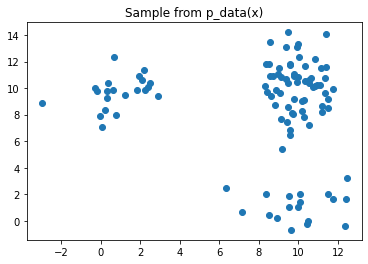

In [3]:
X = sample_pdata(100)

plt.scatter(X[:,0],X[:,1])
plt.title('Sample from p_data(x)')
plt.show()

Next we need a function to sample from the noise distribution:

In [4]:
def sample_noise(m, n):
    return np.random.multivariate_normal([0,0],[[1, 0],[0, 1]], m)   

Let's get a sample from the noise distribution:

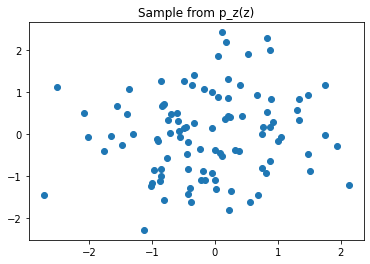

In [5]:
Z = sample_noise(100, 2)

plt.scatter(Z[:,0],Z[:,1])
plt.title('Sample from p_z(z)')
plt.show()

Next, let's define a discriminator and generator:

In [6]:
import torch
import torch.cuda as cuda
import torch.nn as nn
import torch.nn.functional as F

class GeneratorNet(nn.Module):
    def __init__(self):
        super(GeneratorNet, self).__init__()
        # First fully connected layer
        self.fc1 = nn.Linear(2, 20)
        # Second fully connected layer
        self.fc2 = nn.Linear(20, 20)
        self.output = nn.Linear(20, 2)
    
    def forward(self, x):
        # Pass data through fc1
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        output = self.output(x)
        return output
    
class DiscriminatorNet(nn.Module):
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        # First fully connected layer
        self.fc1 = nn.Linear(2, 20)
        # Second fully connected layer
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20,20)
        self.output = nn.Linear(20, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.output(x)
        return F.sigmoid(x)
        

Let's create instances of the generator and discriminator and test that G() can process a sample from the noise distribution and that D() can process a sample from the data distribution or the output of the generator:

In [7]:
# Instantiate the generator and discriminator

G = GeneratorNet()
D = DiscriminatorNet()

# xhat = G(noise sample)

z = torch.tensor(sample_noise(10, 2)).float()
print('Generator input:', z)
xhat = G(z)
print('Generator output:', xhat)

# decisions on fake data = D(G(noise sample))

decisions_fake = D(xhat)
print('Discriminator output for generated data:', decisions_fake)

# decisions on real data = D(data sample)

x = torch.tensor(sample_pdata(10)).float()
decisions_real = D(x)
print('Discriminator output for real data:', decisions_real)

Generator input: tensor([[-0.9736,  0.5162],
        [ 1.1780, -0.1794],
        [ 0.9715,  1.7560],
        [-0.1693, -0.5071],
        [-0.3712, -1.2571],
        [ 1.0432, -1.1430],
        [-1.0730, -1.2330],
        [ 0.9622,  0.3224],
        [-1.0700,  1.2024],
        [-0.6355,  0.9404]])
Generator output: tensor([[-0.0896,  0.2548],
        [ 0.2043,  0.1422],
        [ 0.0421,  0.2053],
        [ 0.0145,  0.1828],
        [ 0.0396,  0.2358],
        [ 0.2597,  0.1074],
        [-0.0419,  0.3299],
        [ 0.1448,  0.1608],
        [-0.0487,  0.2076],
        [-0.0470,  0.1880]], grad_fn=<AddmmBackward0>)
Discriminator output for generated data: tensor([[0.6454],
        [0.6284],
        [0.6378],
        [0.6399],
        [0.6376],
        [0.6253],
        [0.6414],
        [0.6319],
        [0.6435],
        [0.6437]], grad_fn=<SigmoidBackward0>)
Discriminator output for real data: tensor([[0.0520],
        [0.0897],
        [0.1047],
        [0.0331],
        [0.0624],
 

Let's write some code to train these models using the algorithm from Goodfellow et al. (2014):

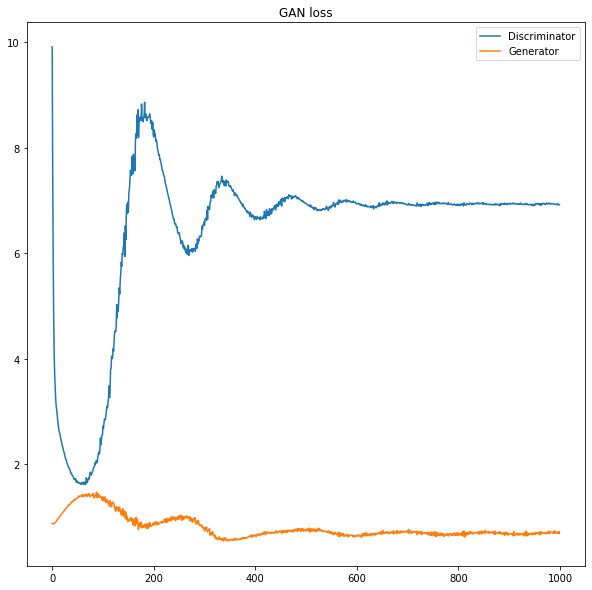

In [8]:
from IPython.display import clear_output
from torch import optim
%matplotlib inline

num_iters = 1000
num_minibatches_discriminator = 5
minibatch_size = 100
n = 2

G = GeneratorNet()
D = DiscriminatorNet()

D_optimizer = optim.Adam(D.parameters(), lr=0.001)
G_optimizer = optim.Adam(G.parameters(), lr=0.001)
loss = nn.BCELoss()

# for number of training iterations

d_losses = []
g_losses = []

def do_plot(d_losses, g_losses):
    plt.figure(figsize=(10,10))
    clear_output(wait=True)
    plt.plot(d_losses, label='Discriminator')
    plt.plot(g_losses, label='Generator')
    plt.title('GAN loss')
    plt.legend()
    plt.show()

G.train()
D.train()

for iter in range(num_iters):
    
    # Train discriminator for num_minibatches_discriminator minibatches

    d_loss = 0
    for discriminator_iter in range(num_minibatches_discriminator):
        D.zero_grad()
        D_optimizer.zero_grad()
        x = torch.tensor(sample_pdata(minibatch_size)).float()
        z = torch.tensor(sample_noise(minibatch_size, n)).float()
        xhat = G(z)
        decisions_real = D(x)
        real_targets = torch.ones(minibatch_size, 1)
        error_real = loss(decisions_real, real_targets)
        error_real.backward()
        decisions_fake = D(xhat)
        fake_targets = torch.zeros(minibatch_size, 1)
        error_fake = loss(decisions_fake, fake_targets)
        error_fake.backward()
        D_optimizer.step()
        d_loss += error_real + error_fake

    # Train generator on one minibatch
    
    G.zero_grad()
    D.zero_grad()
    G_optimizer.zero_grad()
    z = torch.tensor(sample_noise(minibatch_size, n)).float()
    xhat = G(z)
    decisions_fake = D(xhat)
    fake_targets = torch.ones(minibatch_size, 1)
    g_loss = loss(decisions_fake, fake_targets)
    g_loss.backward()
    G_optimizer.step()

    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())
    
    do_plot(d_losses, g_losses)


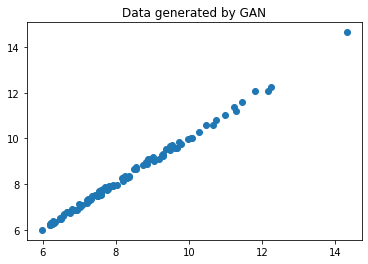

In [9]:
G.eval()
z = torch.tensor(sample_noise(100, 2)).float()
xhat = G(z).detach().numpy()

plt.scatter(xhat[:,0],xhat[:,1])
plt.title('Data generated by GAN')
plt.show()

### Exercise 1 (50 points)

As the results are not yet convincing, perform some further experiments with bigger noise vectors, larger networks, and different hyperparameters to improve the results. In your report, describe your experiments and demonstrate the results.

In [10]:
class GeneratorNet2(nn.Module):
    def __init__(self):
        super(GeneratorNet2, self).__init__()
        # First fully connected layer
        self.fc1 = nn.Linear(2, 10)
        # Second fully connected layer
        self.fc2 = nn.Linear(10, 20)
        self.fc3 = nn.Linear(20, 15)
        self.output = nn.Linear(15, 2)
    
    def forward(self, x):
        # Pass data through fc1
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        output = self.output(x)
        return output
    
class DiscriminatorNet2(nn.Module):
    def __init__(self):
        super(DiscriminatorNet2, self).__init__()
        # First fully connected layer
        self.fc1 = nn.Linear(2,10)
        # Second fully connected layer
        self.fc2 = nn.Linear(10,15)
        self.fc3 = nn.Linear(15,5)
        self.output = nn.Linear(5, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        output = self.output(x)
        return F.sigmoid(output)
        

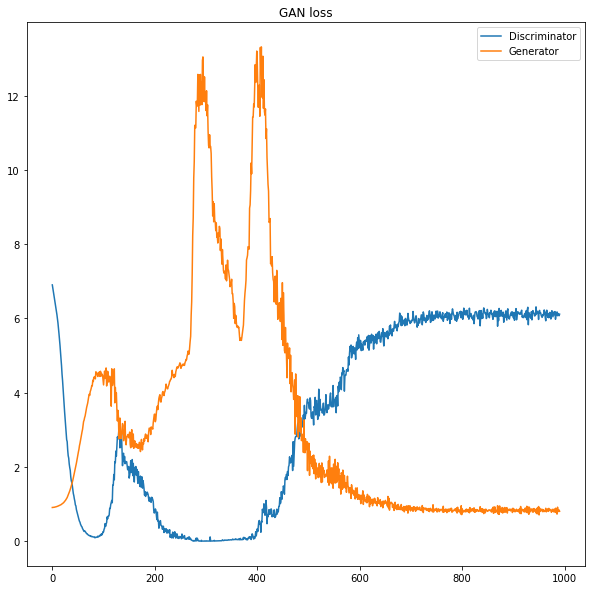

In [11]:
num_iters = 1000
num_minibatches_discriminator = 5
minibatch_size = 100
n = 2

G = GeneratorNet2()
D = DiscriminatorNet2()

if cuda.is_available():
    G = G.cuda()
    D = D.cuda()

D_optimizer = optim.Adam(D.parameters(), lr=0.001)
G_optimizer = optim.Adam(G.parameters(), lr=0.001)
loss = nn.BCELoss()

d_losses = []
g_losses = []

G.train()
D.train()

for iter in range(num_iters):
    
    # Train discriminator for num_minibatches_discriminator minibatches

    d_loss = 0
    for discriminator_iter in range(num_minibatches_discriminator):
        D.zero_grad()
        D_optimizer.zero_grad()
        x = torch.tensor(sample_pdata(minibatch_size)).float()
        z = torch.tensor(sample_noise(minibatch_size, n)).float()
        if cuda.is_available():
            x = x.cuda()
            z = z.cuda()
        xhat = G(z)
        decisions_real = D(x)
        real_targets = torch.ones(minibatch_size, 1)
        if cuda.is_available():
            real_targets = real_targets.cuda()
        error_real = loss(decisions_real, real_targets)
        error_real.backward()
        decisions_fake = D(xhat)
        fake_targets = torch.zeros(minibatch_size, 1)
        if cuda.is_available():
            fake_targets = fake_targets.cuda()
        error_fake = loss(decisions_fake, fake_targets)
        error_fake.backward()
        D_optimizer.step()
        d_loss += error_real + error_fake

    # Train generator on one minibatch
    
    G.zero_grad()
    D.zero_grad()
    G_optimizer.zero_grad()
    z = torch.tensor(sample_noise(minibatch_size, n)).float()
    if cuda.is_available():
        z = z.cuda()
    xhat = G(z)
    decisions_fake = D(xhat)
    fake_targets = torch.ones(minibatch_size, 1)
    if cuda.is_available():
        fake_targets = fake_targets.cuda()
    g_loss = loss(decisions_fake, fake_targets)
    g_loss.backward()
    G_optimizer.step()

    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())
    
    if iter % 10 == 0:
        do_plot(d_losses, g_losses)

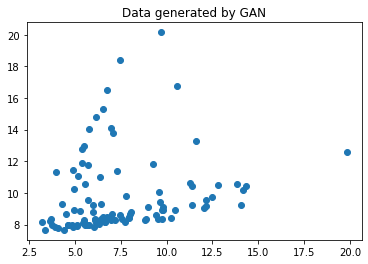

In [12]:
G.eval()
z = torch.tensor(sample_noise(100, 2)).float()
if cuda.is_available():
    z = z.cuda()
xhat = G(z).detach().cpu().numpy()

plt.scatter(xhat[:,0],xhat[:,1])
plt.title('Data generated by GAN')
plt.show()

As I try to increase the number of layer to make model compatible to learn more complex data. The result that generated by GAN is more complex compare to small model. From the loss graph, we can see the change of discriminator and generator. In the first period, Discriminator can learn to fit data very well. Afterward, the generator is become better that make discriminator harder to classify the output correctly. So we can see that the loss of discriminator is more that generator loss.

## Example 2: Deep Convolutional GAN

This DCGAN tutorial is from the [DCGAN Tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) and the data is from [Mckinsey666](https://github.com/Mckinsey666/Anime-Face-Dataset)

The goal of this paper is to generate fake images like as shown below. For this lab we will use 2000 of the original 60,000 images.
![DCGAN Results](https://lh3.googleusercontent.com/2O3GwarTHA1detFNPHfBYAWZTj6ZATp0K1vdHtjdNHlCvQp_bSnXcMRI3oD-EEeCpI4glkcDJaTfniOqKOfsvpP3Hw_7tXIvVOVhLlOST8g1za9cEluoYasl6Vcug8e_88FYdRKuS2kuSCR4LdfHXXv1mJfT_sS8DtWISkmXpJLvlKo7eI9gNhYabfn-A5bk3gkHPqV34HlN2OerJMoACs6rH4AtTC98b02kRhHGOFoCUX20FsTZfkT6feh4Avkwll8fBEvJmKfwzxF0M93YfKSJAntqWddjf3q0rlfOJkeSOwAbJQMyW_jl0ycIDUlCN7lbdmNkB0ikPXKtb0d4cF8V83W_RoK-Nbh2YiI7aSnq4yfgZNxYVm2a-iaEyQWQKD1NK4-3Nv_-picYl0308kVKzJ8C-p31oEkbBwA7YQ50Hezuu09ReKfDBrZvE9sSIn1GTZpHsjYL6dPOExsTz9z6x7J3MmAiAQaForHNaYAR2s05FZbpR3dQ19xFhubcJpP5Z8i7mnjIO52tUxJeg3rpbO6-h1LxmJTD-MCJpY37xoI6vuSk6rlvw-FPi22vDjD6SwewGwYhejmT2GXtGevzFOsUK5lovvx35vRzS0wCdGvA0MxDP5VRdcyn_GG-wQeExWKoj8N8be8bGG4G_eA8eRDs1qkjVizYwDj3rbuvY25okXEl4wVpMz1Cw-9Y1btLxITkgBeeCOY3tLy1CHOohR6HqRHUoV3TbQ9zTYy-2Xvf=w877-h427-no)

The DCGAN is a GAN with a generator designed to do for generate larger RGB images using convolutional layers.

Here is the DCGAN architecture:

<img src="img/dcgan2.png" title="DCGAN" style="width: 640px;" />

First, we import some additional required libraries.

In [77]:
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
seed = 6969
# seed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", seed)
random.seed(seed)
torch.manual_seed(seed)

Random Seed:  6969


Next, we define some important variables.

In [78]:
# Root directory for dataset
dataroot = "/home/maxpasit/Documents/DatasetML/Lab12"

# Number of workers for dataloader
workers = 0

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 100 # Original is 5 on a dataset of 1 million

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

Next, let's create and preview the dataset.

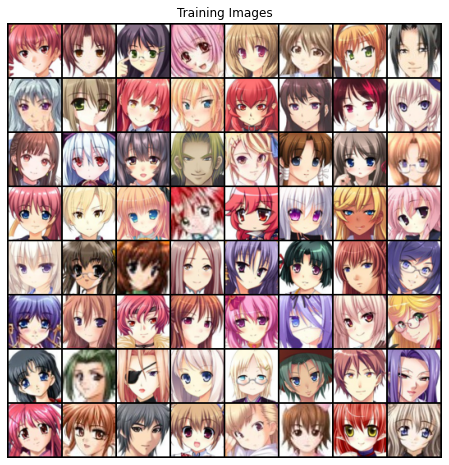

In [79]:
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(enumerate(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[1][0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### Weight initialization

Here is a weight initialization function:

In [80]:
# Custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator

In [81]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [82]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


### Discriminator

In [83]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [84]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


### Loss functions and optimizers

In [85]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

### Training

You will need to follow these conceptual instructions.

1. Create noise
2. Input noise to generator network to get fake images
3. Input fake images to discriminator and detect it that true or false. Calculate $loss_{fake}$ with **True** probability
4. Input real images to discriminator and detect it that true or false. Calculate $loss_{real}$ with **True** probability
5. $loss_{d} = (loss_{fake} + loss_{real})$
6. back propagation discriminator network.
7. Input fake images to discriminator and detect it that true or false. Calculate $loss_{gan}$ with **Fake** probability
8. back propagation generator network.
9. loop it!

In [86]:
num_iters = 300
num_minibatches_discriminator = 5
minibatch_size = 100
n = 2

d_losses = []
g_losses = []

netG.train()
netD.train()

for iter in range(num_iters):

    d_loss = 0
    g_loss = 0
    for data in dataloader:
        # create noise
        noise = torch.randn(batch_size, nz, 1, 1).float()
        if cuda.is_available():
            noise = noise.cuda()
        # get fake image
        genPic = netG(noise)

        # calculate loss fake target
        netD.zero_grad()
        optimizerD.zero_grad()
        decisions_fake = netD(genPic)
        decisions_fake = decisions_fake.reshape(-1)
        fake_target = torch.zeros(batch_size)
        if cuda.is_available():
            fake_target = fake_target.cuda()
        loss_fake = criterion(decisions_fake, fake_target)

        # calculate loss real target
        real_data = data[0]
        if cuda.is_available():
            real_data = real_data.cuda()
        
        decisions_real = netD(real_data)
        decisions_real = decisions_real.reshape(-1)
        real_target = torch.ones(batch_size)
        if cuda.is_available():
            real_target = real_target.cuda()
        loss_real = criterion(decisions_real, real_target)

        # calculate discriminator loss
        lossD = loss_fake + loss_real

        # back prop discriminator
        lossD.backward()
        optimizerD.step()

        # input fake image to discriminator
        noise = torch.randn(batch_size, nz, 1, 1).float()
        if cuda.is_available():
            noise = noise.cuda()
        fake_img = netG(noise)
        decisions_fake = netD(fake_img)
        decisions_fake = decisions_fake.reshape(-1)
        fake_target = torch.ones(batch_size)
        if cuda.is_available():
            fake_target = fake_target.cuda()
        lossG = criterion(decisions_fake, fake_target)
        # back prop generator
        netG.zero_grad()
        optimizerG.zero_grad()
        lossG.backward()
        optimizerG.step()

        # sum loss 
        d_loss += lossD
        g_loss += lossG

    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

UnidentifiedImageError: cannot identify image file <_io.BufferedReader name='/home/maxpasit/Documents/DatasetML/Lab12/cropped/4221_2002.jpg'>

### Plot losses

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Visualize the training process

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

### Display final results

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

### Take-home exercise (50 points)

Find another interesting image generation application of the DCGAN and implement it. Demonstate your results in your report.